# NestorFlow (anag.)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Define the number of live points `n_live`, the number of parameters in the model `n_dims`, the number of slice steps to take to get uncorrelated samples `n_repeats`, and the maximum number of iterations of the nested sampler `max_depth`. I think these will have to stay global (or at least defined within a class eventually).

In [2]:
n_live = 250
n_dims = 25
n_repeats = n_dims * 2
max_depth = 100

The nested sampler itself is a while loop to run until convergence (based on the evidence) or a maximum depth. The evidence is calculated in the condition using all past dead points (actually their likelihood).

The body takes the current live points and appends them to the dead points (and the same for the likelihoods). It then runs the slice sampler loop to obtain the new live points and their likelihoods.

An interesting TensorFlow point here. To avoid growing (concatenating) Tensors I have defined a fixed sized variable. This is a bit of a funny quirk (like all the other quirks) of TensorFlow in that we have to define the variable in the loop but then state that it is to be reused to prevent it creating a new tensor on every run of the loop. It seems to work pretty well.

Notice now how we don't call any functions in the loop (because this will build new tensors). Instead we just run the while loop for the slice_sampler and we can define the functions for the slice sampler separately.

In [3]:
def nested_condition(live_points, L, depth):
    dead_L = tf.get_variable("dead_L", 
                             (max_depth, n_live), 
                             dtype=tf.float32, 
                             initializer=tf.constant_initializer(0.))
    n_live_fl = tf.cast(n_live, dtype=tf.float32)
    depth_fl = tf.cast(depth, dtype=tf.float32)
    grid = tf.range(tf.multiply(n_live_fl, depth_fl), dtype=tf.float32)
    current_dead_L = tf.sort(tf.reshape(tf.slice(dead_L, [0, 0], [depth, -1]), (-1,)))
    logw = tf.add(
        tf.subtract(
            tf.math.log(tf.math.sinh(tf.divide(tf.cast(1., dtype=tf.float32), n_live_fl))),
            tf.divide(grid, n_live_fl)),
        current_dead_L)
    logZ = tf.math.reduce_logsumexp(logw)
    live_logZ = tf.reduce_max(tf.subtract(L, depth_fl))
    with tf.control_dependencies([dead_L]):
        return tf.greater(live_logZ, logZ + tf.cast(tf.log(1e-2), dtype=tf.float32))

def nested_body(live_points, L, depth):
    dead_points = tf.get_variable("dead_points", 
                                  (max_depth, n_live, n_dims), 
                                  dtype=tf.float32, 
                                  initializer=tf.constant_initializer(0.))
    tf.get_variable_scope().reuse_variables()
    dead_L = tf.get_variable("dead_L", (max_depth, n_live), dtype=tf.float32)
    dead_points = tf.scatter_update(dead_points, depth, live_points)
    dead_L = tf.scatter_update(dead_L, depth, L)
    repeats = tf.constant(0)
    live_points, L, _ = tf.while_loop(slice_condition, 
                                      slice_body, 
                                      [live_points, L, repeats])
    with tf.control_dependencies([dead_points, dead_L]):
        return [live_points, L, tf.add(depth, 1)]

The slice sampler runs a single slice sample `n_repeats` times to obtain uncorrelated samples. Each slice needs a uniform sample of live points and the value of the posterior isocontour in the random left and right direction of each point.

The slice sampler therefore has three while loops in its body, but notice that there are no functions. The while loops are for finding the left bound, finding the right bound and then doing a single slice step.

I remember that we added `w` as a random direction and length to step within the bounds, but actually going through the code we appear not be using it for anything - maybe this needs updating.

In [4]:
def slice_condition(live_points, L, repeats):
    return tf.less(repeats, n_repeats)

def slice_body(live_points, L, repeats):
    
    directions = direction.sample((n_live, n_dims))
    n_hat = tf.divide(directions, tf.norm(directions, axis=1, keepdims=True))
    u = prior.sample((n_live, 1))
    
    l_bound_init = tf.add(live_points, tf.multiply(n_hat, tf.subtract(u, 1)))
    l_L_init = likelihood.log_prob(l_bound_init)
    l_L_init = tf.where(tf.reduce_any(tf.less(l_bound_init, 0.), axis=1), 
                        tf.math.log(tf.zeros_like(l_L_init)), 
                        l_L_init)
    l_bound, l_L, _, _ = tf.while_loop(
        left_condition, 
        left_body, 
        [l_bound_init, l_L_init, L, n_hat])
    
    r_bound_init = tf.add(live_points, tf.multiply(n_hat, u))
    r_L_init = likelihood.log_prob(r_bound_init)
    r_L_init = tf.where(tf.reduce_any(tf.greater(r_bound_init, 1.), axis=1), 
                        tf.math.log(tf.zeros_like(r_L_init)), 
                        r_L_init)
    r_bound, r_L, _, _ = tf.while_loop(
        right_condition, 
        right_body, 
        [r_bound_init, r_L_init, L, n_hat])
    
    #w = tf.einsum("ij,ij->i", n_hat, tf.subtract(r_bound, l_bound))
    #w appears not to be used unless it is in rhs in slice_step_body and we don't explicitly need it?
    u2 = prior.sample((n_live, 1))
    
    live_points_init = tf.add(tf.multiply(tf.subtract(r_bound, l_bound), u2), l_bound)
    live_L_init = likelihood.log_prob(live_points_init)
    _, _, live_points, L, _, _, _, _, _, _, _ = tf.while_loop(
        slice_step_condition, 
        slice_step_body,
        [live_points, L, live_points_init, live_L_init,
         l_bound, l_L, l_bound, r_bound, r_L, r_bound, n_hat])
    
    return [live_points, L, tf.add(repeats, 1)]

The left and right bounds are also calculated in while loops. Each of them takes a step (either left or right) along the unit direction of each live point until the bound is inside the current value of the likelihood at that live point.

Finally - these bodies do not contain any while loops!

In [5]:
def left_condition(l_bound, l_L, min_L, n_hat):
    return tf.reduce_any(tf.math.greater_equal(l_L, min_L))

def left_body(l_bound, l_L, min_L, n_hat):
    l_bound_next = tf.subtract(l_bound, 
                               tf.where(tf.math.greater_equal(l_L, min_L), 
                                        n_hat, 
                                        tf.zeros_like(n_hat)))
    l_L_next = likelihood.log_prob(l_bound_next)
    l_L_next = tf.where(tf.reduce_any(tf.less(l_bound_next, 0.), axis=1),
                        tf.math.log(tf.zeros_like(l_L_next)), 
                        l_L_next)
    return [l_bound_next, l_L_next, min_L, n_hat]

In [6]:
def right_condition(r_bound, r_L, min_L, n_hat):
        return tf.reduce_any(tf.math.greater_equal(r_L, min_L))

def right_body(r_bound, r_L, min_L, n_hat):
    r_bound_next = tf.add(r_bound, 
                          tf.where(tf.math.greater_equal(r_L, min_L), 
                                   n_hat, 
                                   tf.zeros_like(n_hat)))
    r_L_next = likelihood.log_prob(r_bound_next)
    r_L_next = tf.where(tf.reduce_any(tf.greater(r_bound_next, 1.), axis=1),
                        tf.math.log(tf.zeros_like(r_L_next)), 
                        r_L_next)
    return [r_bound_next, r_L_next, min_L, n_hat]

The single slice first works out whether a live point will move right or left and then draws a new sample and calculates the likelihood of the new point. The condition is reached when all new likelihoods are higher than the previous likelihood.

Notice here how we do not call a likelihood function (or create a uniform prior for the position of the new sample) we just evaluate its log probability.

In [7]:
def slice_step_condition(live_points, L, live_points_next, L_next, l_b, l_L, l_bound, r_b, r_L, r_bound, n_hat):
    return tf.reduce_any(tf.less(L_next, L))

def slice_step_body(live_points, L, live_points_next, L_next, l_b, l_L, l_bound, r_b, r_L, r_bound, n_hat):
    out = tf.less(L_next, L)
    rhs = tf.math.greater_equal(
        tf.einsum("ij,ij->i", 
                  n_hat, 
                  tf.subtract(live_points_next,
                              live_points)), 
        tf.zeros(n_live))
    move_left = tf.logical_and(out, tf.logical_not(rhs))
    l_bound_next = tf.where(move_left, live_points_next, l_bound)
    l_L_next = likelihood.log_prob(l_bound_next)
    move_right = tf.logical_and(out, rhs)
    r_bound_next = tf.where(move_right, live_points_next, r_bound)
    r_L_next = likelihood.log_prob(r_bound_next)
    u3 = prior.sample((n_live, 1))
    live_points_next = tf.where(
        out, 
        tf.add(tf.multiply(tf.subtract(r_bound_next, l_bound_next), u3), 
               l_bound_next), 
        live_points_next)
    L_next = likelihood.log_prob(live_points_next)
    return [live_points, L, live_points_next, L_next, l_bound_next, l_L_next, l_bound, r_bound_next, r_L_next, r_bound, n_hat]

We set up the likelihood to be evaluated $\mathcal{L}=\mathcal{N}(\textrm{vec}(0.5; n_\textrm{dims}), \textrm{diag}(0.1; n_\textrm{dims}))$ and the prior hypercube $\mathcal{U}=[0, 1]$. We also need a generator for random directions which is defined by $\mathcal{N}(0, 1)$. Unfortunately I think these will have to remain global because only `Tensors` can be passed through the loops. 

The truncation of the likelihood is done in the loop to avoid adding tensors... fun hey!? As far as I can tell the truncation is only needed in the slice sampler loop and in the right and left bound loops. I don't think there is any need for it in the single slice sweep because the steps are already bounded by the left and right bounds already found. If this is incorrect then the where condition needs propogating to the other functions too

In [8]:
likelihood = tfp.distributions.MultivariateNormalDiag(
    loc=(np.ones(n_dims)*0.5).astype(np.float32), 
    scale_diag=(np.ones(n_dims)*0.1).astype(np.float32))
prior = tfp.distributions.Uniform()
direction = tfp.distributions.Normal(loc=0., scale=1.)

We can now draw our live points and calculate their probability (not evaluated... of course)

In [9]:
live_points = prior.sample((n_live, n_dims))
L = likelihood.log_prob(live_points)

The counter for the maximum number of iterations is also defined. This is useful because if the sampler stops because of the evidence condition the depth parameter will be the number of indices which are non-zero in the dead points array.

In [10]:
depth = tf.constant(0)

Now we can finally define the nested sampler loop! This is going to return our live points, their likelihoods and the number of iterations of that the nested sampler took.

In [11]:
nested_sampler  = tf.while_loop(nested_condition,
                                nested_body, 
                                [live_points, L, depth],
                                maximum_iterations=max_depth)

Instructions for updating:
Colocations handled automatically by placer.


To actually grab our dead points and their likelihoods we need to grab the tensors that we define inside the nested sampler loop!

In [12]:
dead_points = tf.get_variable("dead_points", (max_depth, n_live, n_dims), dtype=tf.float32)
dead_L = tf.get_variable("dead_L", (max_depth, n_live), dtype=tf.float32)

Finally, we define the initialiser function for the graph

In [13]:
init = tf.global_variables_initializer()

And begin the session and actually initialise everything!

In [14]:
sess = tf.Session()
sess.run(init)

Now we run the sampler! Yippee!

In [15]:
nested_samples, dead_p, dead_likelihoods = sess.run([nested_sampler, dead_points, dead_L])

# Verification

I'm going to make the animation through the dead points to check that they are moving inwards

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

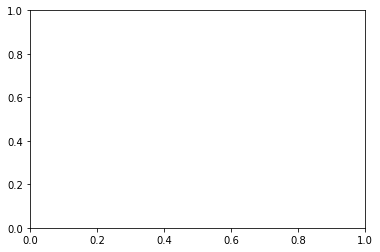

In [17]:
fig, ax = plt.subplots()

ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

line, = ax.plot([], [], ".")

In [18]:
def init():
    line.set_data([], [])
    return (line,)

In [19]:
def animate(i):
    line.set_data(dead_p[i, :, 0], dead_p[i, :, 1])
    return (line,)

In [20]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=min(nested_samples[2], max_depth), interval=100, blit=True)

In [21]:
HTML(anim.to_html5_video())